# Import packages

In [16]:
import numpy as np
import time
import matplotlib.pyplot as plt

Utility function

In [20]:
def u(c):
    return np.log(c)

# Looped VFI

In [21]:
def Tv(d, toler, max_iter, alpha, beta, n, A):

    K_ss = (( alpha * beta * A) / (1 - beta * (1 - d)))** (1/(1 - alpha))

    k = np.linspace(K_ss * 0.75, K_ss * 1.25, n)

    v=np.zeros(shape=(n,1)) 

    v1=np.zeros(shape=(n,1)) 

    v1=np.zeros(shape=(n,1))

    policy=np.zeros(shape=(n,1))

    distance=np.zeros(shape=(n,1)) 

    start_time = time.time()
    #Start with iteration 0\n",
    iter = 1
    #We need to set an initial error\n",
    error = toler+1 
    #While these two conditions are true, do this.\n",
    while (toler<error) and (iter<max_iter):
    #That is, for each element of the capital grid, perform the following:\n",
        for i in range(len(k)):
    #We need to set an initial value for vmax. As soon as we do something, this will update\n",
            vmax = -np.inf
        #Fixing an element in the grid, calculate consumption and the value of selecting each feasible capital stock tomorrow\n",
            for j in range(len(k)):
                    #Consumption\n",
                        c = A * k[i] ** alpha + (1-d) * k[i] - k[j] 
                    #remember that c must be nonnegative\n",
                        if c>=0: 
                        #calculate the value using the consumption from above, and the current element j of the value function, which represents the value of having that capital stock tomorrow.\n",
                            v_temp = u(c)+beta*v[j] 
                        #if the choice j' is better than j, then\n",
                            if v_temp>vmax: 
                            #set j' as the new best choice\n",
                                vmax=v_temp 
                            #and set that choice j' as the policy for element i of the capital stock\n",
                                policy_i=k[j]
                   #Now, once we have found vmax for a given i, set element i of the new value function to be that value \n",
                        v1[i]=vmax 
                    #Find the new policy function by setting element i to be the best choice j'\n",
                        policy[i]=policy_i 
                    #new distance\n",
                        distance[i]=np.abs(vmax-v[i]) 
            #set new error\n",
        error=np.max(distance) 
            #set v as the new calculation v1       
        v=np.copy(v1) 

        if iter  == 1:
            print(f"Iteration {iter}, Max Error: {error}")

        if iter % 10 == 0:
            #print Iteration number and error size every 10 iterations\n",
            print(f"Iteration {iter}, Max Error: {error}") 
        iter+=1
   
        if iter == max_iter:
            #if we don't converge, let me know\n",
            print("Failed to converge in max_iter iterations") 
        # Record end time\n",
    end_time = time.time() 
        #how long did it take? \n",
    execution_time = end_time - start_time 
    print(f"Execution time: {execution_time} seconds")
       #give me the value fuction and the policy function



    a0 = (np.log(A) + (1 - alpha * beta) * np.log(1 - alpha * beta) + alpha * beta * np.log(alpha * beta)) / ((1 - beta) * (1 - alpha * beta))

    a1 = alpha / (1 - alpha * beta)

    plt.plot(k, v, label = 'vfi')
    plt.plot(k, a0 + a1 * np.log(k), label = 'verify')
    plt.title('Value Function')
    plt.xlabel('k')
    plt.ylabel("v")
    plt.legend()
    plt.show()

    plt.plot(k, policy, label = 'vfi')
    plt.plot(k, A * beta * alpha * k ** alpha, label = 'verify')
    plt.title('Policy Function')
    plt.xlabel('k')
    plt.ylabel("k")
    plt.legend()
    plt.show()
    return v, policy 

Iteration 1, Max Error: 2.500745114574248
Iteration 10, Max Error: 0.004531865190639195
Iteration 20, Max Error: 4.425648167938334e-06
Execution time: 178.32129764556885 seconds


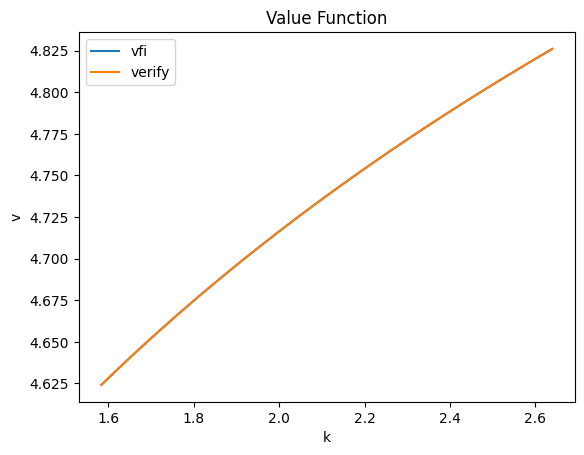

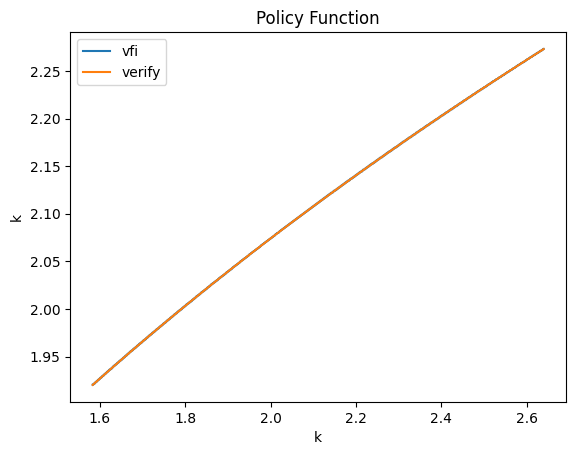

In [22]:
v_output, pol_output = Tv(d=1, toler=1e-6, max_iter=10000000, alpha=0.33, beta=0.5, n=1001, A=10)

# Vectorised VFI

Note the speed up relative to the looped VFI code.

In [23]:
def Tv_vec(delt, max_iteration, grid_size, A, alph, bet, toler):
    K_ss = (( alph * bet * A) / (1 - bet * (1 - delt)))** (1/(1 - alph))

    k = np.linspace(K_ss * 0.75, K_ss * 1.25, grid_size)[:, None]

    v = np.zeros(shape=(grid_size,1))

    policy=np.zeros(shape=(grid_size,1))

    start_time=time.time()

    iter = 1

    if iter == 1:
        print("Iterating...")

    error=toler+1

        # Now, take advantage of broadcasting\n",
        # First, calculate consumption. This code will produce a matrix of size (grid_size, grid_size)
        # where element (i,j) corresponds to consumption for capital i today and capital j tomorrow.
        # We can calculate consumption outside the loop since each element will always be the same.

    c = A * k ** (alph) + ( 1 - delt ) * k - k.T

    while (toler < error) and (iter < max_iteration):

            # In principle, the above code could allow for negative consumption. We prevent that next.
            # For np.where(condition, x, y) means that x will be applied when the condition is true, and y when false.

        v_temp = np.where(c > 0, u(c) + bet * v.T, -np.inf)

            # Below, u is applied element-wise to c_pos, creating an (grid_size, grid_size) vector
            # as v it (grid_size, 1), we add it to each column of u(c_pos). This is what we mean by broadcasting.\
            # So, v_temp_i,j = u(c)_i,j + beta * v_j.

            # Now, we maximise over the rows, since each row corresponds to a different current capital stock.
            # That is, for a given i, look at each column and pick the best

        vmax = np.max(v_temp, axis=1)[:, np.newaxis]

            # Similarly, find the policy function

        policy_idx = np.argmax(v_temp, axis=1)

            # Extract the corresponding capital stock

        policy=k[policy_idx]

            # Update value function and calculate distance

        v1 = vmax.copy()

        distance = np.abs(v1 - v)

        error = np.max(distance)

        v=v1.copy()

        if iter  == 1:
            print(f"Iteration {iter}, Max Error: {error}")

        if iter % 10 == 0:
            print(f"Iteration {iter}, Max Error: {error}")
        iter +=1

        if iter == max_iteration:
           print("Failed to converge in max_iter iterations")

    end_time = time.time()

    execution_time = end_time - start_time

    print(f"Execution time: {execution_time} seconds")

    a0 = (np.log(A) + (1 - alph * bet) * np.log(1 - alph * bet) + alph * bet * np.log(alph * bet)) / ((1 - bet) * (1 - alph * bet))

    a1 = alph / (1 - alph * bet)

    plt.plot(k, v, label = 'vfi')
    plt.plot(k, a0 + a1 * np.log(k), label = 'verify')
    plt.title('Value Function')
    plt.xlabel('k')
    plt.ylabel("v")
    plt.legend()
    plt.show()

    plt.plot(k, policy, label = 'vfi')
    plt.plot(k, A * bet * alph * k ** alph, label = 'verify')
    plt.title('Policy Function')
    plt.xlabel('k')
    plt.ylabel("k")
    plt.legend()
    plt.show()

    return v, policy

Iterating...
Iteration 1, Max Error: 2.500745114574248
Iteration 10, Max Error: 0.004531865190639195
Iteration 20, Max Error: 4.425648167938334e-06
Execution time: 0.36113429069519043 seconds


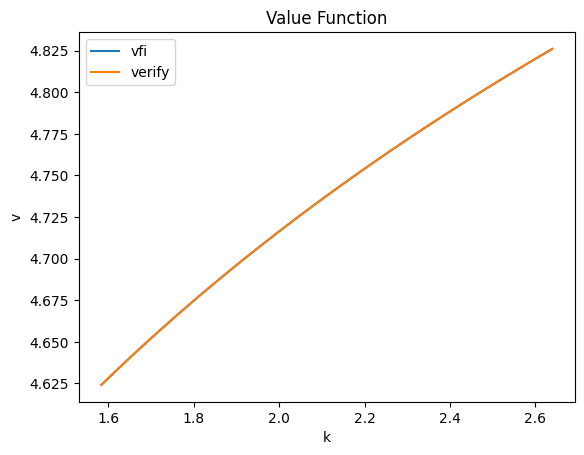

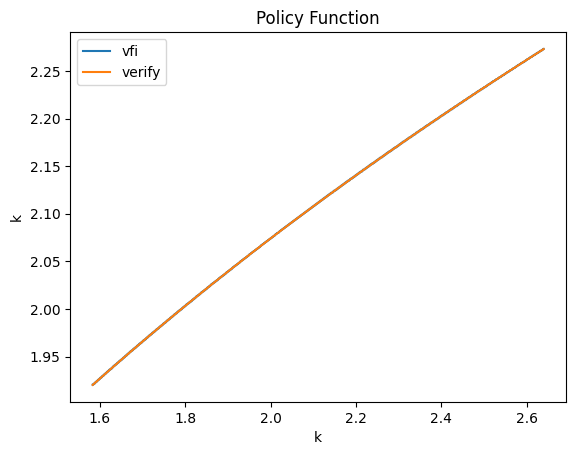

In [24]:
v_out, pol_out = Tv_vec(delt=1, max_iteration=1e10, grid_size=1001, A=10, alph=0.33, bet=0.5, toler=1e-6)

# Now, let's add the MQP bounds

First, add the bounds to the looped VFI code

In [25]:
def Tv_mqp(d, toler, max_iter, alpha, beta, A, n):

    K_ss = (( alpha * beta * A) / (1 - beta * (1 - d))) ** (1/(1 - alpha))

    k = np.linspace(K_ss * 0.75, K_ss * 1.25, n)

    v = np.zeros(shape=(n,1))

    start_time = time.time()

    iter = 1 

    error = toler + 1

    idx=np.zeros(shape=(n,1), dtype=int)

    v1=np.zeros(shape=(n,1))

    v2=np.zeros(shape=(n,1))

    vect_c=np.zeros(shape=(n,1))

    if iter == 1:
        print("Iterating...") 
    
    while (toler<error) and (iter<max_iter): 
        policy_i=np.zeros(shape=(n,1))
        for i in range(len(k)):
            vmax = -np.inf 
            for j in range(len(k)):
                c = A * k[i] ** alpha + (1-d) * k[i] - k[j] 
                if c>=0: 
                    v_temp = u(c)+beta*v[j] 
                    if v_temp>vmax: 
                        vmax=v_temp 
                        policy_i[i]=k[j]
                        idx[i]=j
                v1[i]=vmax 

        v2=np.copy(v1)

        vect_c = v2 - v

        c_low =  np.min(vect_c) * (beta / (1 - beta))

        c_high = np.max(vect_c) * (beta / (1 - beta)) 

        v = v2 + (c_low + c_high)/2

        error = c_high - c_low

        if iter % 10 == 0:
            print(f"Iteration {iter}, Max Error: {error}")
             
        iter+=1

    if iter == max_iter:
        print("Failed to converge in max_iter iterations") 

    end_time = time.time()  

    execution_time = end_time - start_time 
    
    print(f"Execution time: {execution_time} seconds")

    a0 = (np.log(A) + (1 - alpha * beta) * np.log(1 - alpha * beta) + alpha * beta * np.log(alpha * beta)) / ((1 - beta) * (1 - alpha * beta))

    a1 = alpha / (1 - alpha * beta)

    plt.plot(k, v, label = 'vfi')
    plt.plot(k, a0 + a1 * np.log(k), label = 'verify')
    plt.title('Value Function')
    plt.xlabel('k')
    plt.ylabel("v")
    plt.legend()
    plt.show()

    plt.plot(k, policy_i, label = 'vfi')
    plt.plot(k, A * beta * alpha * k ** alpha, label = 'verify')
    plt.title('Policy Function')
    plt.xlabel('k')
    plt.ylabel("k")
    plt.legend()
    plt.show()
    return v, policy_i 


Iterating...
Execution time: 40.98730206489563 seconds


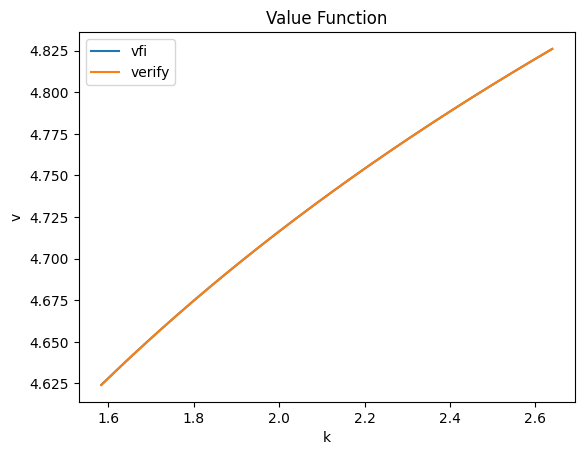

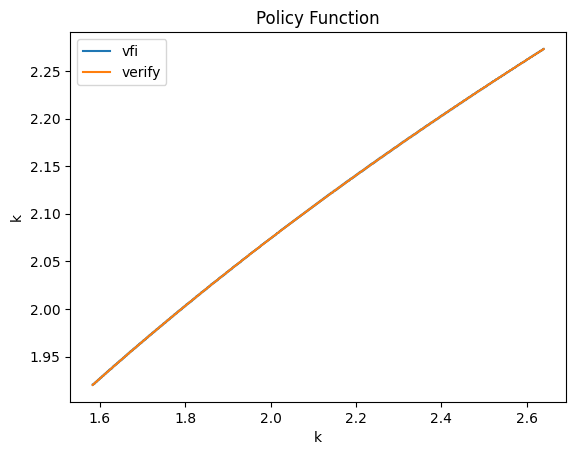

In [26]:
v_mqp, pol_mqp = Tv_mqp(d=1, toler=1e-6, max_iter=1000000, alpha=0.33, beta=0.5, A=10, n=1001)

Now, let's turn to the Vectorised code

In [84]:
def Tv_vec_mqp(delt, max_iteration, grid_size, A, alph, bet, toler):
    
    K_ss = (( alph * bet * A) / (1 - bet * (1 - delt)))** (1/(1 - alph))

    k = np.linspace(K_ss * 0.75, K_ss * 1.25, grid_size)[:, None]

    v = np.zeros(shape=(grid_size,1))

    policy=np.zeros(shape=(grid_size,1))

    start_time=time.time()

    iter = 1

    if iter == 1:
        print("Iterating...")

    error=toler+1

    # Now, take advantage of broadcasting\n",
    # First, calculate consumption. This code will produce a matrix of size (grid_size, grid_size)\n",
    # where element (i,j) corresponds to consumption for capital i today and capital j tomorrow.\n"
    # Note that we can take the calculation of consumption outside the loop since each element will always be the same.

    c = A * k ** (alph) + ( 1 - delt ) * k - k.T

    while (toler < error) and (iter < max_iteration):
            # In principle, the above code could allow for negative consumption. We prevent that next.
            # For np.where(condition, x, y) means that x will be applied when the condition is true, and y when false.
            # Below, u is applied element-wise to c_pos, creating an (grid_size, grid_size) vector
            # as v it (grid_size, 1), we add it to each column of u(c_pos). This is what we mean by broadcasting.
            # So, v_temp_i,j = u(c)_i,j + beta * v_j.\n",

        v_temp = np.where(c > 0, u(c) + bet * v.T, -np.inf)

            # Now, we maximise over the rows, since each row corresponds to a different current capital stock.
            # That is, for a given i, look at each column and pick the best

        vmax = np.max(v_temp, axis=1)[:, np.newaxis]

            # Similarly, find the policy function

        policy_idx = np.argmax(v_temp, axis=1)

            # Extract the corresponding capital stock

        policy=k[policy_idx]


            # Update value function and calculate distance

        v1 = vmax.copy()

        vec_c = v1 - v

        c_high = (bet/(1-bet)) * np.max(vec_c)

        c_low = (bet/(1-bet)) * np.min(vec_c)        
        
        error = c_high - c_low

        v = v1 + (c_high + c_low)/2

        if iter == 1:
            print(f"Iteration {iter}, Max Error: {error}")

        if iter % 10 == 0:
            print(f"Iteration {iter}, Max Error: {error}")

        iter +=1

        if iter == max_iteration:
           print("Failed to converge in max_iter iterations")

    end_time = time.time()

    execution_time = end_time - start_time

    print(f"Execution time: {execution_time} seconds")

    a0 = (np.log(A) + (1 - alph * bet) * np.log(1 - alph * bet) + alph * bet * np.log(alph * bet)) / ((1 - bet) * (1 - alph * bet))

    a1 = alph / (1 - alph * bet)

    plt.plot(k, v, label = 'vfi')
    plt.plot(k, a0 + a1 * np.log(k), label = 'verify')
    plt.title('Value Function')
    plt.xlabel('k')
    plt.ylabel("v")
    plt.legend()
    plt.show()

    plt.plot(k, policy, label = 'vfi')
    plt.plot(k, A * bet * alph * k ** alph, label = 'verify')
    plt.title('Policy Function')
    plt.xlabel('k')
    plt.ylabel("k")
    plt.legend()
    plt.show()

    return v, policy

Iterating...
[[1.58366809]
 [1.58366809]
 [1.58366809]
 ...
 [1.58366809]
 [1.58366809]
 [1.58366809]]
Iteration 1, Max Error: 0.19271269425676385
[[1.85394744]
 [1.85394744]
 [1.85500322]
 ...
 [2.17912729]
 [2.18018307]
 [2.18018307]]
[[1.90884793]
 [1.90884793]
 [1.90990371]
 ...
 [2.25831069]
 [2.25831069]
 [2.25831069]]
[[1.91834994]
 [1.91834994]
 [1.91940572]
 ...
 [2.26992426]
 [2.26992426]
 [2.27098004]]
[[1.9204615 ]
 [1.9204615 ]
 [1.9204615 ]
 ...
 [2.27203582]
 [2.27203582]
 [2.27203582]]
[[1.9204615 ]
 [1.9204615 ]
 [1.92151728]
 ...
 [2.27203582]
 [2.27309159]
 [2.27309159]]
[[1.9204615 ]
 [1.9204615 ]
 [1.92151728]
 ...
 [2.27203582]
 [2.27309159]
 [2.27309159]]
Execution time: 0.2093672752380371 seconds


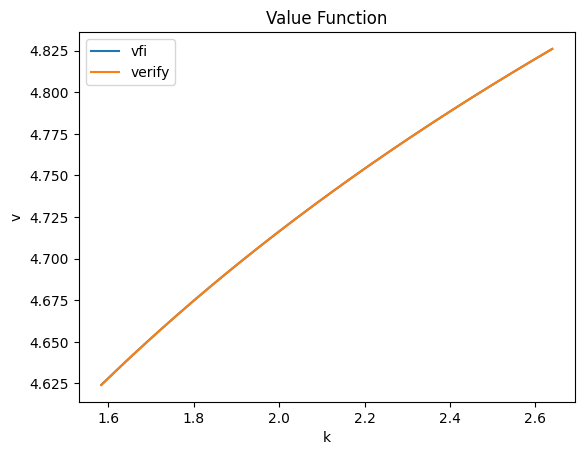

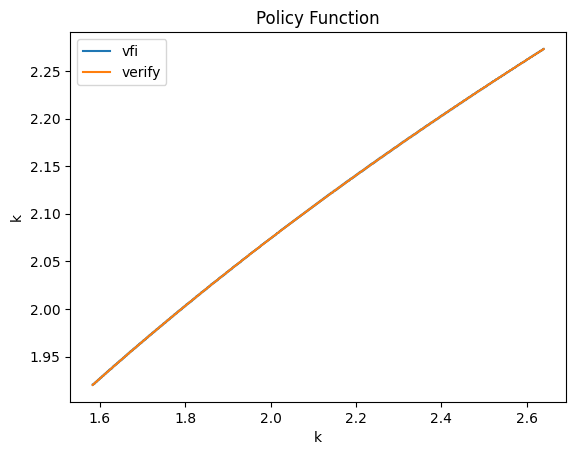

In [87]:
mqp_v, mqp_pol = Tv_vec_mqp(delt=1, max_iteration=10000000, grid_size=1001, A=10, alph=0.33, bet=0.5, toler=1e-6)

# Howard Policy Iteration

Now, let's add Howard to our code. First, we add Howard to out looped code, and then we turn to our vectorised code.

Looped

In [29]:
def Tv_howard(m, d, toler, alpha, A, grid_size, max_iter, beta):
    start_time = time.time()
    iter = 1 
    error = toler+1
    idx=np.zeros(shape=(grid_size,1), dtype=int)
    v=np.zeros(shape=(grid_size,1))
    v1=np.zeros(shape=(grid_size,1))
    v2=np.zeros(shape=(grid_size,1))
    K_ss = (( alpha * beta * A) / (1 - beta * (1 - d)))** (1/(1 - alpha))
    k = np.linspace(K_ss * 0.75, K_ss * 1.25, grid_size)
    if iter == 1:
        print("Iterating...")
    while (toler<error) and (iter<max_iter): 
        distance=np.zeros(shape=(grid_size,1)) 
        policy_i=np.zeros(shape=(grid_size,1))
        for i in range(len(k)):
            vmax = -np.inf 
            for j in range(len(k)):
                c = A * k[i] ** alpha + (1-d) * k[i] - k[j] 
                if c>=0: 
                    v_temp = u(c)+beta*v[j] 
                    if v_temp>vmax: 
                        vmax=v_temp 
                        policy_i[i]=k[j]
                        idx[i]=j
                v1[i]=vmax
        for _ in range(m):
            for i in range(len(k)):
                j=idx[i]
                c = A * k[i] ** alpha + (1-d) * k[i] - policy_i[i]
                v2[i]=u(c)+beta*v1[j]
            v1=v2.copy()           
        for i in range(len(k)):
            distance[i]=np.abs(v1[i]-v[i])
        error=np.max(distance)
        v=np.copy(v1)
        if iter  == 1:
            print(f"Iteration {iter}, Max Error: {error}")
        if iter % 10 == 0:
                print(f"Iteration {iter}, Max Error: {error}")
        iter+=1
    if iter == max_iter:
        print("Failed to converge in max_iter iterations")
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

    a0 = (np.log(A) + (1 - alpha * beta) * np.log(1 - alpha * beta) + alpha * beta * np.log(alpha * beta)) / ((1 - beta) * (1 - alpha * beta))

    a1 = alpha / (1 - alpha * beta)

    plt.plot(k, v, label = 'vfi')
    plt.plot(k, a0 + a1 * np.log(k), label = 'verify')
    plt.title('Value Function')
    plt.xlabel('k')
    plt.ylabel("v")
    plt.legend()
    plt.show()

    plt.plot(k, policy_i, label = 'vfi')
    plt.plot(k, A * beta * alpha * k ** alpha, label = 'verify')
    plt.title('Policy Function')
    plt.xlabel('k')
    plt.ylabel("k")
    plt.legend()
    plt.show()
    return v, policy_i

Iterating...
Iteration 1, Max Error: 4.736651521756811
Execution time: 28.98970365524292 seconds


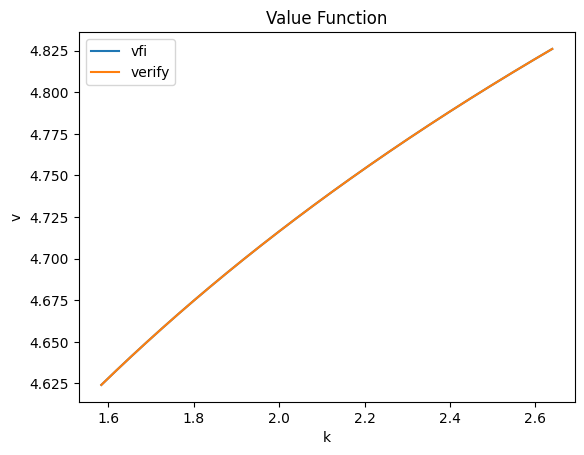

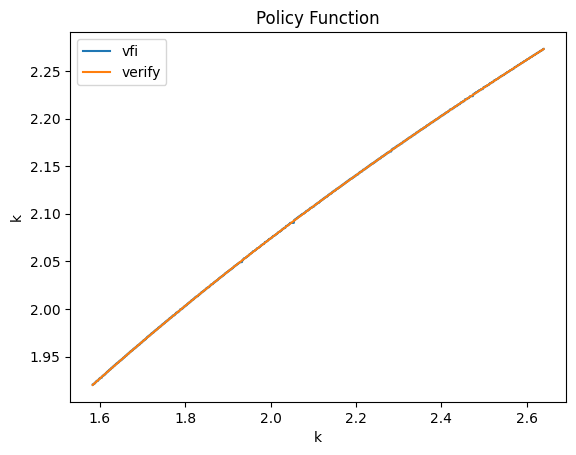

In [30]:
v_how, pol_how = Tv_howard(m=5, d=1, toler=1e-6, alpha=0.33, A=10, grid_size=1001, max_iter=1000000, beta=0.5)

Vectorised

In [98]:
def Tv_vec_how(delt, max_iteration, grid_size, A, alph, bet, toler, max_howard):

    K_ss = (( alph * bet * A) / (1 - bet * (1 - delt)))** (1/(1 - alph))

    k = np.linspace(K_ss * 0.75, K_ss * 1.25, grid_size)[:, None]

    # a0 = (np.log(A) + (1 - alph * bet) * np.log(1 - alph * bet) + alph * bet * np.log(alph * bet)) / ((1 - bet) * (1 - alph * bet))
    
    # 1 = alph / (1 - alph * bet)

    # v = a0 + a1 * np.log(k)

    v = np.zeros(shape=(grid_size,1))

    policy=np.zeros(shape=(grid_size,1))

    start_time=time.time()

    iter = 1
        
    if iter == 1:
        print("Iterating...")

    error = toler + 1

    c = A * (k ** (alph)) + ( 1 - delt ) * k - k.T

    while (toler < error) and (iter < max_iteration):

        v_temp = np.where(c > 0, u(c) + bet * v.T, -np.inf)
  
        v1 = np.max(v_temp, axis=1)[:, np.newaxis]

        policy_idx = np.argmax(v_temp, axis=1)
   
        policy=k[policy_idx]

        c_howard = A * (k ** alph) + (1-delt) * k - policy

        c_pos_howard = np.where(c_howard > 0, c_howard, 1)
    
        for _ in range(max_howard):
    
            v_temp_howard = np.where(c_pos_howard>0, u(c_pos_howard) + bet * v1, -np.inf)
            
            v1 = v_temp_howard.copy()

        distance = np.abs(v1-v)
    
        error = np.max(distance)
    
        v = v1.copy()
    
        if iter % 1 == 0:
            print(f"Iteration {iter}, Max Error: {error}")
    
        iter +=1
    
    if iter == max_iteration:
        print("Failed to converge in max_iteration iterations")
    
    end_time = time.time()
    
    execution_time = end_time - start_time
    
    print(f"Execution time: {execution_time} seconds")
    
    a0 = (np.log(A) + (1 - alph * bet) * np.log(1 - alph * bet) + alph * bet * np.log(alph * bet)) / ((1 - bet) * (1 - alph * bet))
    
    a1 = alph / (1 - alph * bet)
    
    plt.plot(k, v, label='vfi')
    plt.plot(k, a0 + a1 * np.log(k), label = 'verify')
    plt.title('Value Function')
    plt.xlabel('k')
    plt.ylabel("v")
    plt.legend()
    plt.show()
    
    plt.plot(k, policy, label='vfi')
    plt.plot(k, A * bet * alph * k ** alph, label = 'verify')
    plt.title('Policy Function')
    plt.xlabel('k')
    plt.ylabel("k'")
    plt.legend()
    plt.show()

    return v, policy

Iterating...
[[3.46204863]
 [3.49896554]
 [3.5335337 ]
 [3.5660304 ]
 [3.59668681]
 [3.62569765]
 [3.65322845]
 [3.67942107]
 [3.70439804]
 [3.72826585]
 [3.75111767]]
Iteration 1, Max Error: 3.751117671861372
[[4.24520665]
 [4.27461266]
 [4.31307645]
 [4.34914547]
 [4.38309415]
 [4.41515274]
 [4.44551623]
 [4.4743512 ]
 [4.50180103]
 [4.52799002]
 [4.55302659]]
Iteration 2, Max Error: 0.8019089190890818
[[4.4339007 ]
 [4.47508989]
 [4.51355368]
 [4.5496227 ]
 [4.58357138]
 [4.61562997]
 [4.64599346]
 [4.67482843]
 [4.70227826]
 [4.72846725]
 [4.75350382]]
Iteration 3, Max Error: 0.20047722977227167
[[4.48402001]
 [4.5252092 ]
 [4.56367299]
 [4.59974201]
 [4.63369069]
 [4.66574927]
 [4.69611276]
 [4.72494773]
 [4.75239757]
 [4.77858656]
 [4.80362313]]
Iteration 4, Max Error: 0.050119307443068806
[[4.49654983]
 [4.53773902]
 [4.57620282]
 [4.61227184]
 [4.64622052]
 [4.6782791 ]
 [4.70864259]
 [4.73747756]
 [4.7649274 ]
 [4.79111639]
 [4.81615296]]
Iteration 5, Max Error: 0.012529826860

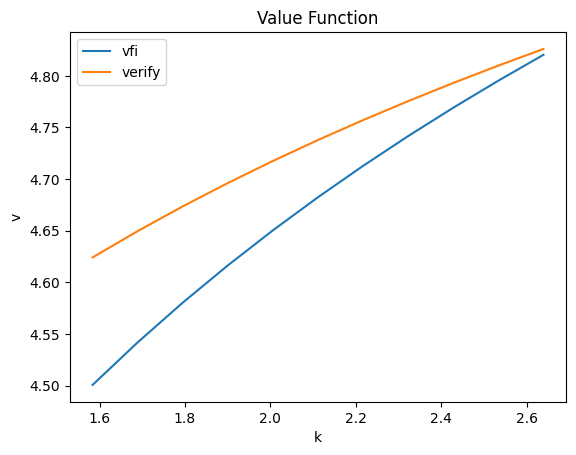

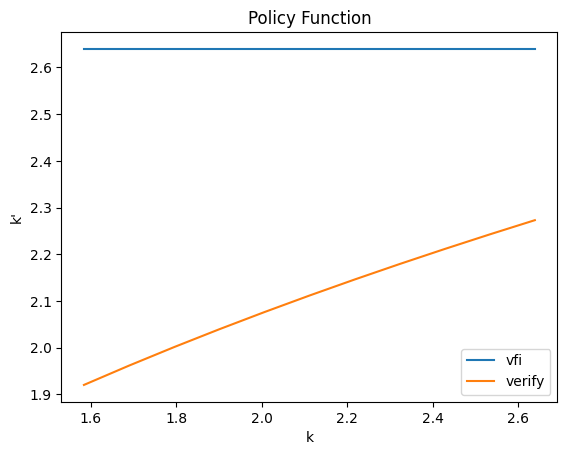

In [99]:
vec_how_v, vec_how_pol = Tv_vec_how(delt=1, max_iteration=2000000, grid_size=11, A=10, alph=0.33, bet=0.5, toler=1e-6, max_howard=1)
# print(vec_how_v)
